In [3]:
# In a new Jupyter cell, copy and paste all of this code:

import h5py
import numpy as np

def print_structure(name, obj):
    """Recursively prints the structure of an HDF5 group."""
    indent = '  ' * name.count('/')
    if isinstance(obj, h5py.Group):
        print(f"{indent}Group: {name}")
    elif isinstance(obj, h5py.Dataset):
        print(f"{indent}Dataset: {name} | Shape: {obj.shape} | Dtype: {obj.dtype}")

def inspect_amr_file(filepath):
    """Opens an AMR HDF5 file and prints its complete structure."""
    try:
        with h5py.File(filepath, 'r') as f:
            print("="*60)
            print(f"Inspecting file: {filepath}")
            print("="*60)
            
            print("\n--- Full File Structure ---")
            f.visititems(print_structure)
            
            print("\n--- Data Array Analysis ---")
            available_levels = sorted([key for key in f.keys() if key.startswith('level_')])
            
            for level_key in available_levels:
                level_group = f[level_key]
                print(f"\nAnalyzing Group: '{level_key}'")
                
                if 'data:datatype=0' in level_group:
                    data_array = level_group['data:datatype=0']
                    print(f"  Found 'data:datatype=0' with shape: {data_array.shape}")
                    
                    if 'boxes' in level_group:
                        boxes = level_group['boxes'][:]
                        # Handle cases where offsets might be missing for some reason
                        if 'data:offsets=0' in level_group:
                            n_vars = len(level_group['data:offsets=0'][:]) - 1
                        else:
                            # A reasonable fallback if offsets aren't present
                            n_vars = 4 
                        
                        total_cells = 0
                        for box in boxes:
                            ni = box['hi_i'] - box['lo_i'] + 1
                            nj = box['hi_j'] - box['lo_j'] + 1
                            total_cells += ni * nj
                        
                        expected_size = total_cells * n_vars
                        actual_size = data_array.size
                        
                        print(f"  Box metadata implies {total_cells} cells and {n_vars} variables.")
                        print(f"  --> Expected data array size: {expected_size}")
                        print(f"  --> Actual data array size:   {actual_size}")
                        if expected_size == actual_size:
                            print("  ✅ Sizes match!")
                        else:
                            print("  ❌ Sizes DO NOT match!")
                    else:
                        print("  'boxes' dataset not found in this level.")
                else:
                    print("  'data:datatype=0' dataset NOT found in this level.")
            print("\n" + "="*60)

    except Exception as e:
        print(f"An error occurred: {e}")

# --- Set the file path here ---
file_to_inspect = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/dynamic_AMR/AMR_3LevelRefinement_dynamic/shockTubeAMR_3dynamic.plot.000001.2d.hdf5"

# --- Run the inspection ---
inspect_amr_file(file_to_inspect)

Inspecting file: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/dynamic_AMR/AMR_3LevelRefinement_dynamic/shockTubeAMR_3dynamic.plot.000001.2d.hdf5

--- Full File Structure ---
Group: Chombo_global
Group: Expressions
Group: level_0
  Dataset: level_0/Processors | Shape: (4,) | Dtype: int32
  Dataset: level_0/boxes | Shape: (4,) | Dtype: {'names': ['lo_i', 'lo_j', 'hi_i', 'hi_j'], 'formats': ['<i4', '<i4', '<i4', '<i4'], 'offsets': [0, 4, 8, 12], 'itemsize': 20}
  Dataset: level_0/data:datatype=0 | Shape: (16384,) | Dtype: float64
  Dataset: level_0/data:offsets=0 | Shape: (5,) | Dtype: int64
  Group: level_0/data_attributes
Group: level_1
  Dataset: level_1/Processors | Shape: (4,) | Dtype: int32
  Dataset: level_1/boxes | Shape: (4,) | Dtype: {'names': ['lo_i', 'lo_j', 'hi_i', 'hi_j'], 'formats': ['<i4', '<i4', '<i4', '<i4'], 'offsets': [0, 4, 8, 12], 'itemsize': 20}
  Dataset: level_1/data:datatype=0 | Shape: (16384,) | Dtype: float64
  Dataset: level_

In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import json
from datetime import datetime
from collections import defaultdict

class AMRShockTubeProcessor:
    """
    Processor for shock tube simulations with AMR (Adaptive Mesh Refinement).
    Handles multiple refinement levels (0, 1, 2, 3) with refinement ratio 2:1.
    """
    
    def __init__(self, data_dir, amr_level, strategy='composite'):
        self.data_dir = Path(data_dir)
        self.max_amr_level = amr_level
        self.strategy = strategy
        self.domain_length = 1.0
        self.domain_height = 0.5
        self.delta_t = 0.002
        self.base_grid_size = 64
        self.var_names = ['density', 'x_momentum', 'y_momentum', 'total_energy']
        self.finest_grid_size = self.base_grid_size * (2 ** amr_level)
        
        print(f"Initialized AMR Processor:")
        print(f"  Max AMR Level: {amr_level}")
        print(f"  Strategy: {strategy}")
        print(f"  Base grid: {self.base_grid_size}x{self.base_grid_size}")
        print(f"  Finest grid for this run: {self.finest_grid_size}x{self.finest_grid_size}")
        print(f"  Domain: {self.domain_length}m x {self.domain_height}m")
        print(f"  Timestep: {self.delta_t}s")

    def get_timestep_files(self):
        files = [f for f in self.data_dir.glob('*.plot.*.2d.hdf5') if '.map.' not in f.name]
        if not files:
            print(f"  Warning: No HDF5 files found in: {self.data_dir}")
        
        def extract_timestep(filename):
            match = re.search(r'\.(\d+)\.2d\.hdf5', str(filename))
            return int(match.group(1)) if match else 0
        
        return sorted(files, key=extract_timestep)

    def read_amr_data_all_levels(self, filename):
        levels_data = {}
        try:
            with h5py.File(filename, 'r') as f:
                available_levels = [key for key in f.keys() if key.startswith('level_')]
                
                for level_key in sorted(available_levels):
                    level_num = int(level_key.split('_')[1])
                    if level_num > self.max_amr_level:
                        continue
                    
                    level_group = f[level_key]

                    if 'data:datatype=0' not in level_group or 'boxes' not in level_group:
                        print(f"  Warning: Missing 'data' or 'boxes' in {level_key} for file {filename}")
                        continue
                    
                    data_flat = level_group['data:datatype=0'][:]
                    boxes = level_group['boxes'][:]
                    n_vars = len(self.var_names)
                    
                    cells_per_dim = self.base_grid_size * (2 ** level_num)
                    dx = self.domain_length / cells_per_dim
                    dy = self.domain_height / cells_per_dim
                    
                    levels_data[level_num] = {
                        'boxes': boxes, 'data_flat': data_flat, 'n_vars': n_vars,
                        'cell_size': (dx, dy), 'cells_per_dim': cells_per_dim
                    }
        except Exception as e:
            print(f"  ERROR: Failed to read HDF5 file {filename}. Error: {e}")
            return {}
        return levels_data

    def reconstruct_composite_grid(self, levels_data):
        finest_size = self.finest_grid_size
        grids = {var: np.zeros((finest_size, finest_size)) for var in self.var_names}

        for level_num in sorted(levels_data.keys()):
            level_info = levels_data.get(level_num)
            if not level_info: continue

            data_flat, boxes, n_vars = level_info['data_flat'], level_info['boxes'], level_info['n_vars']
            scale = 2 ** (self.max_amr_level - level_num)
            
            # --- THE FINAL, CRUCIAL FIX ---
            # Sort boxes by column index ('lo_i') first, then row index ('lo_j').
            boxes = np.sort(boxes, order=['lo_i', 'lo_j'])

            data_idx = 0
            for box in boxes:
                ni, nj = box['hi_i'] - box['lo_i'] + 1, box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                required_size = box_size * n_vars

                if data_idx + required_size > len(data_flat):
                    print(f"  Warning: Data array for LEVEL {level_num} is smaller than expected. Skipping remaining boxes.")
                    break

                box_data = data_flat[data_idx : data_idx + required_size]
                data_idx += required_size

                i_start, i_end = box['lo_i'] * scale, (box['hi_i'] + 1) * scale
                j_start, j_end = box['lo_j'] * scale, (box['hi_j'] + 1) * scale

                for var_idx, var_name in enumerate(self.var_names):
                    var_data_slice = box_data[var_idx * box_size : (var_idx + 1) * box_size]
                    
                    # Use default C-ordering for the reshape
                    var_data_2d = var_data_slice.reshape((nj, ni))
                    
                    var_data_fine = np.repeat(np.repeat(var_data_2d, scale, axis=0), scale, axis=1) if scale > 1 else var_data_2d
                    
                    grids[var_name][j_start:j_end, i_start:i_end] = var_data_fine
        
        return grids

    def _create_uniform_grid_edges(self, grid_size):
        nodes = np.arange(grid_size * grid_size).reshape(grid_size, grid_size)
        edges = []
        for i in range(grid_size):
            for j in range(grid_size - 1):
                edges.extend([[nodes[i, j], nodes[i, j+1]], [nodes[i, j+1], nodes[i, j]]])
        for i in range(grid_size - 1):
            for j in range(grid_size):
                edges.extend([[nodes[i, j], nodes[i+1, j]], [nodes[i+1, j], nodes[i, j]]])
        return torch.tensor(edges, dtype=torch.long).t().contiguous()

    def process_to_pyg(self, output_dir="amr_processed"):
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        files = self.get_timestep_files()
        print(f"\nFound {len(files)} timestep files.")
        if len(files) < 2:
            print("  Error: Need at least 2 timesteps for training pairs.")
            return None
        
        pyg_data_list = []
        edge_index = self._create_uniform_grid_edges(self.finest_grid_size)
        x_coords, y_coords = torch.linspace(0, 1, self.finest_grid_size), torch.linspace(0, 1, self.finest_grid_size)
        pos = torch.stack(torch.meshgrid(x_coords, y_coords, indexing='xy'), dim=-1).reshape(-1, 2)
        
        for i in range(len(files) - 1):
            print(f"  Processing timestep pair {i} -> {i+1}...")
            levels_current, levels_next = self.read_amr_data_all_levels(files[i]), self.read_amr_data_all_levels(files[i+1])
            if not levels_current or not levels_next:
                print("  Skipping pair due to read error.")
                continue
            
            grids_current, grids_next = self.reconstruct_composite_grid(levels_current), self.reconstruct_composite_grid(levels_next)
            features_current = np.stack([grids_current[var] for var in self.var_names], axis=-1).reshape(-1, len(self.var_names))
            features_next = np.stack([grids_next[var] for var in self.var_names], axis=-1).reshape(-1, len(self.var_names))
            x, y = torch.cat([pos, torch.tensor(features_current, dtype=torch.float)], dim=1), torch.tensor(features_next, dtype=torch.float)
            pyg_data_list.append(Data(x=x, edge_index=edge_index, pos=pos, y=y, timestep_current=i, amr_level=self.max_amr_level, delta_t=self.delta_t))
        
        print(f"\nProcessed {len(pyg_data_list)} timestep pairs.")
        output_file = output_path / f"amr_level_{self.max_amr_level}_{self.strategy}.pt"
        torch.save(pyg_data_list, output_file)
        print(f"Saved to: {output_file}")
        
        metadata = {'timestamp': datetime.now().isoformat(), 'max_amr_level': self.max_amr_level, 'strategy': self.strategy, 'base_grid_size': self.base_grid_size, 'finest_grid_size': self.finest_grid_size, 'domain_size': [self.domain_length, self.domain_height], 'delta_t': self.delta_t, 'n_timestep_pairs': len(pyg_data_list), 'n_files': len(files), 'variable_names': self.var_names}
        with open(output_path / f"amr_level_{self.max_amr_level}_metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)
        return pyg_data_list

def main():
    no_refinement_dir = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement")
    dynamic_amr_base = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/dynamic_AMR")
    output_base = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_processed")
    
    print("="*80 + "\nPROCESSING AMR SHOCK TUBE DATA\n" + "="*80)
    
    print("\n" + "="*80 + "\nPROCESSING: No Refinement (Level 0)\n" + "="*80)
    processor_0 = AMRShockTubeProcessor(data_dir=no_refinement_dir, amr_level=0)
    processor_0.process_to_pyg(output_dir=str(output_base / "level_0_no_refinement"))
    
    for level in [1, 2, 3]:
        print("\n" + "="*80 + f"\nPROCESSING: Dynamic AMR Level {level}\n" + "="*80)
        level_dir = dynamic_amr_base / f"AMR_{level}LevelRefinement_dynamic"
        if not level_dir.exists():
            print(f"WARNING: Directory not found: {level_dir}")
            continue
        processor = AMRShockTubeProcessor(data_dir=level_dir, amr_level=level)
        data = processor.process_to_pyg(output_dir=str(output_base / f"level_{level}_dynamic"))
        if data:
            print(f"\nSuccessfully processed level {level}: {len(data)} timestep pairs.")
    
    print("\n" + "="*80 + "\nPROCESSING COMPLETE\n" + "="*80)
    print(f"All outputs saved to: {output_base}")

if __name__ == "__main__":
    main()

PROCESSING AMR SHOCK TUBE DATA

PROCESSING: No Refinement (Level 0)
Initialized AMR Processor:
  Max AMR Level: 0
  Strategy: composite
  Base grid: 64x64
  Finest grid for this run: 64x64
  Domain: 1.0m x 0.5m
  Timestep: 0.002s

Found 101 timestep files.
  Processing timestep pair 0 -> 1...
  Processing timestep pair 1 -> 2...
  Processing timestep pair 2 -> 3...
  Processing timestep pair 3 -> 4...
  Processing timestep pair 4 -> 5...
  Processing timestep pair 5 -> 6...
  Processing timestep pair 6 -> 7...
  Processing timestep pair 7 -> 8...
  Processing timestep pair 8 -> 9...
  Processing timestep pair 9 -> 10...
  Processing timestep pair 10 -> 11...
  Processing timestep pair 11 -> 12...
  Processing timestep pair 12 -> 13...
  Processing timestep pair 13 -> 14...
  Processing timestep pair 14 -> 15...
  Processing timestep pair 15 -> 16...
  Processing timestep pair 16 -> 17...
  Processing timestep pair 17 -> 18...
  Processing timestep pair 18 -> 19...
  Processing timestep

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
import json
import h5py
import re

class AMRDataVisualizer:
    """
    Visualize processed AMR shock tube data across different refinement levels.
    """
    
    def __init__(self, processed_dir, raw_data_base_dir):
        self.processed_dir = Path(processed_dir)
        self.raw_data_base_dir = Path(raw_data_base_dir)
        self.var_names = ['density', 'x_momentum', 'y_momentum', 'total_energy']
        
    def load_level_data(self, level):
        """Load processed data and metadata for a specific AMR level."""
        level_dir_name = "level_0_no_refinement" if level == 0 else f"level_{level}_dynamic"
        level_dir = self.processed_dir / level_dir_name
        
        data_file = level_dir / f"amr_level_{level}_composite.pt"
        meta_file = level_dir / f"amr_level_{level}_metadata.json"
        
        if not data_file.exists():
            print(f"Data file not found: {data_file}")
            return None, None
        
        data_list = torch.load(data_file, weights_only=False)
        with open(meta_file, 'r') as f:
            metadata = json.load(f)
        return data_list, metadata

    def _get_raw_boxes(self, level, timestep_idx):
        """
        Helper to find the correct raw HDF5 file and read its 'boxes' metadata.
        """
        if level == 0:
            raw_dir = self.raw_data_base_dir / "no_refinement"
        else:
            raw_dir = self.raw_data_base_dir / "dynamic_AMR" / f"AMR_{level}LevelRefinement_dynamic"

        if not raw_dir.exists():
            print(f"Raw data directory not found: {raw_dir}")
            return None, 0, 0

        # Find the specific file for the given timestep index
        files = sorted([f for f in raw_dir.glob('*.plot.*.2d.hdf5') if '.map.' not in f.name], 
                       key=lambda f: int(re.search(r'\.(\d+)\.2d\.hdf5', str(f)).group(1)))
        
        if timestep_idx >= len(files):
            print(f"Timestep file for index {timestep_idx} not found in {raw_dir}")
            return None, 0, 0
        
        filepath = files[timestep_idx]

        with h5py.File(filepath, 'r') as f:
            level_key = f'level_{level}'
            if level_key in f and 'boxes' in f[level_key]:
                boxes = f[level_key]['boxes'][:]
                
                # Calculate cell size for this level to convert indices to physical coords
                base_grid_size = 64
                domain_length = 1.0
                domain_height = 0.5
                cells_per_dim = base_grid_size * (2**level)
                dx = domain_length / cells_per_dim
                dy = domain_height / cells_per_dim
                return boxes, dx, dy
        return None, 0, 0

    def extract_grid_from_data(self, data_obj, grid_size, source='x'):
        """Extract 2D grids from a PyG Data object."""
        tensor_data = data_obj.x[:, 2:].numpy() if source == 'x' else data_obj.y.numpy()
        grids = {var: tensor_data[:, i].reshape(grid_size, grid_size) for i, var in enumerate(self.var_names)}
        return grids
        
    def plot_nested_boundaries(self, timestep_idx=0, save_path=None):
        """
        Overlays the boundaries of coarser refined regions on the finest grid
        by reading the 'boxes' directly from the source HDF5 files.
        """
        levels_to_outline = [0, 1, 2]
        background_level = 3
        
        # 1. Load the finest level data for the background plot
        data_list_bg, metadata_bg = self.load_level_data(background_level)
        if data_list_bg is None or timestep_idx >= len(data_list_bg): 
            print("Could not load background data for Level 3.")
            return
        
        grid_size_bg = metadata_bg['finest_grid_size']
        grids_bg = self.extract_grid_from_data(data_list_bg[timestep_idx], grid_size_bg)
        density_bg = grids_bg['density']
        
        # 2. Create the plot
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        im = ax.imshow(density_bg, origin='lower', cmap='viridis', extent=[0, 1.0, 0.5, 0])
        ax.set_title(f'Nested AMR Boundaries on Level {background_level} Density (t={timestep_idx})',
                     fontsize=14, fontweight='bold')
        
        # 3. Read raw box data and draw rectangles for each level
        colors = ['white', 'cyan', 'magenta']
        legend_handles = []

        for i, level in enumerate(levels_to_outline):
            boxes, dx, dy = self._get_raw_boxes(level, timestep_idx)
            if boxes is None:
                continue
            
            # Draw each box as a rectangle
            for j, box in enumerate(boxes):
                lo_i, hi_i, lo_j, hi_j = box['lo_i'], box['hi_i'], box['lo_j'], box['hi_j']
                
                # Convert index coordinates to physical domain coordinates
                x, y = lo_i * dx, lo_j * dy
                width, height = (hi_i - lo_i + 1) * dx, (hi_j - lo_j + 1) * dy
                
                # Create and add the patch
                rect = Rectangle((x, y), width, height, 
                                 linewidth=1.5, edgecolor=colors[i], facecolor='none')
                ax.add_patch(rect)

            # Add a handle for the legend (only one per level)
            legend_handles.append(Rectangle((0,0), 1, 1, color=colors[i], label=f'Level {level} Boundary'))

        # 4. Finalize plot
        ax.legend(handles=legend_handles)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Density', fontsize=11)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"Saved to: {save_path}")
        else:
            plt.show()
        plt.close()

def main():
    """Example usage: visualize AMR shock tube data."""
    processed_dir = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_processed"
    # This needs to point to the base directory containing the original HDF5 files
    raw_data_dir = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube"
    output_dir = Path("amr_visualizations_final")
    output_dir.mkdir(exist_ok=True)
    
    viz = AMRDataVisualizer(processed_dir=processed_dir, raw_data_base_dir=raw_data_dir)
    
    print("\nCreating AMR nested boundaries plot...")
    viz.plot_nested_boundaries(timestep_idx=50,
                               save_path=output_dir / "amr_nested_boundaries_t50_corrected.png")
    
    print(f"\nAll visualizations saved to: {output_dir}")

if __name__ == "__main__":
    main()


Creating AMR nested boundaries plot...
Saved to: amr_visualizations_final/amr_nested_boundaries_t50_corrected.png

All visualizations saved to: amr_visualizations_final


Loading data from: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_processed/level_3_dynamic/amr_level_3_composite.pt
Plotting a 12x12 subset from the center of the graph...


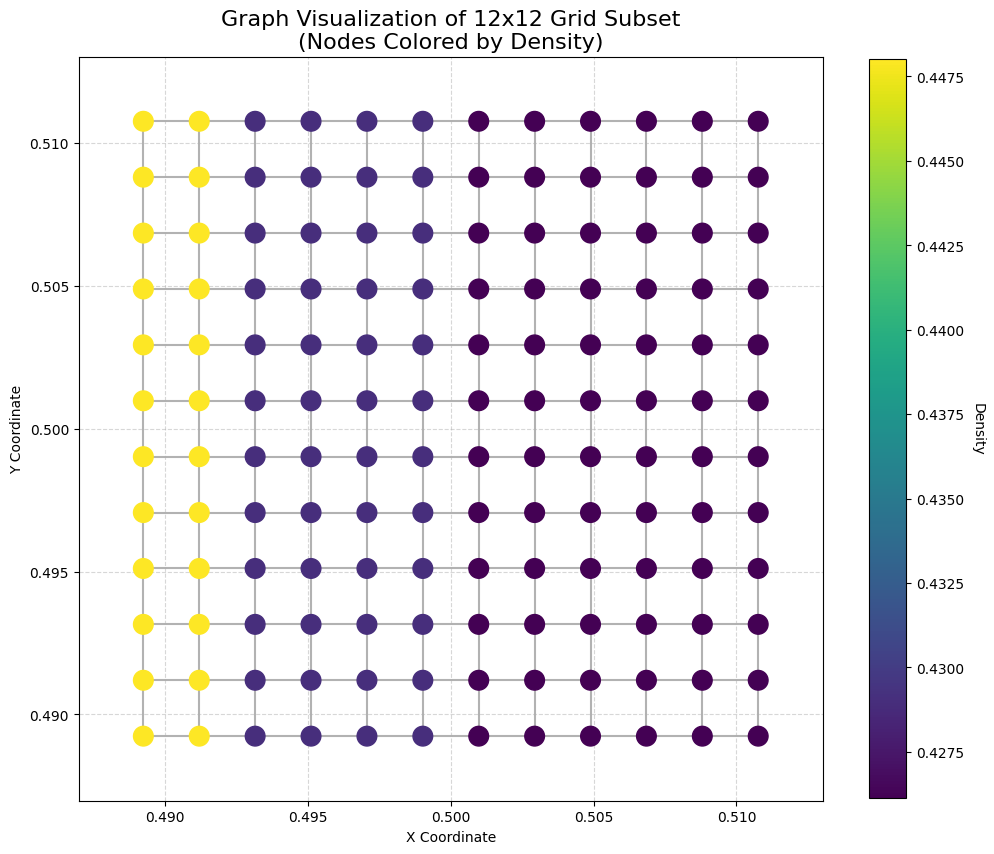

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_as_graph(data_file_path, timestep_idx=0, grid_subset_size=12):
    """
    Loads a processed PyG Data object and visualizes a subset of it as a regular graph.

    Args:
        data_file_path (str or Path): Path to the saved .pt file.
        timestep_idx (int): The timestep to visualize from the list of saved data.
        grid_subset_size (int): The size of the square subset to plot (e.g., 12 for a 12x12 corner).
    """
    data_file = Path(data_file_path)
    if not data_file.exists():
        print(f"Error: File not found at {data_file}")
        return

    print(f"Loading data from: {data_file}")
    data_list = torch.load(data_file,weights_only = False)
    
    if timestep_idx >= len(data_list):
        print(f"Error: Timestep index {timestep_idx} is out of bounds.")
        return

    data_obj = data_list[timestep_idx]
    
    # --- 1. Identify the nodes for the subset ---
    full_grid_size = int(np.sqrt(data_obj.num_nodes))
    if grid_subset_size > full_grid_size:
        print(f"Warning: Subset size ({grid_subset_size}) is larger than grid size ({full_grid_size}). Using full size.")
        grid_subset_size = full_grid_size

    nodes_to_keep = []
    # We'll view a small patch from the middle of the grid
    start_row = (full_grid_size // 2) - (grid_subset_size // 2)
    start_col = (full_grid_size // 2) - (grid_subset_size // 2)

    for i in range(grid_subset_size):      # Rows
        for j in range(grid_subset_size):  # Columns
            node_idx = (start_row + i) * full_grid_size + (start_col + j)
            nodes_to_keep.append(node_idx)

    # --- 2. Convert to NetworkX and create the subgraph ---
    full_graph = to_networkx(data_obj, to_undirected=True)
    subgraph = full_graph.subgraph(nodes_to_keep)

    # --- 3. Prepare data for plotting ---
    positions = {node: data_obj.pos[node].numpy() for node in subgraph.nodes()}
    # Density is the 3rd column (index 2) in our feature tensor 'x'.
    node_colors = [data_obj.x[node, 2].item() for node in subgraph.nodes()]

    # --- 4. Plot the graph ---
    print(f"Plotting a {grid_subset_size}x{grid_subset_size} subset from the center of the graph...")
    fig, ax = plt.subplots(figsize=(12, 12))

    nx.draw_networkx_edges(subgraph, pos=positions, ax=ax, alpha=0.6, width=1.5, edge_color='grey')
    nodes = nx.draw_networkx_nodes(subgraph, pos=positions, ax=ax, node_size=200, node_color=node_colors, cmap=plt.cm.viridis)

    ax.set_title(f"Graph Visualization of {grid_subset_size}x{grid_subset_size} Grid Subset\n(Nodes Colored by Density)", fontsize=16)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlabel("X Coordinate"); ax.set_ylabel("Y Coordinate")
    ax.set_aspect('equal')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.8)
    cbar.set_label("Density", rotation=270, labelpad=15)
    
    plt.show()

# --- Point this to your highest-resolution processed file ---
processed_file = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_processed/level_3_dynamic/amr_level_3_composite.pt"

visualize_as_graph(
    data_file_path=processed_file,
    timestep_idx=50,
    grid_subset_size=12  # We'll look at a 12x12 patch
)